In [403]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# url = 'https://github.com/JeffSackmann/tennis_atp/blob/aade0d19524855adb4d65782f5eec495fb8479d6/atp_matches_2023.csv'
urls = ['atp_matches_2021.csv','atp_matches_2022.csv','atp_matches_2023.csv']

df = pd.concat([pd.read_csv(urls[0]), pd.read_csv(urls[1]), pd.read_csv(urls[2])])

# encode counties as binary
countries_encoded = pd.get_dummies(df[['winner_ioc', 'loser_ioc']])

#create unique match ID
df['match_id'] = df['tourney_id'].astype(str) + '-' + df['match_num'].astype(str)

df = df[df.tourney_level != 'D'] # exclude Davis Cup
df.sort_values(by=['tourney_date', 'tourney_id', 'match_num'], inplace=True)
df.groupby(['winner_id']).cumcount().add(1) 
df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'match_id'],
      dtype='object')

In [341]:
metadata = df[list(filter(re.compile('.*name').match, df.columns))]
# match_pre_data = np.array()
matchplay_stats = pd.concat([df[list(filter(re.compile('^w_|winner_rank$').match, df.columns))], df[list(filter(re.compile('^l_|loser_rank$').match, df.columns))]], axis = 1)

# col_types = np.array()

In [342]:
# for each predictor, calculate the difference between the winner and loser value, and append it to new df

num_preds = int(len(matchplay_stats.columns) / 2)

matchplay_stats_agg = pd.DataFrame()
for i in np.arange(num_preds):
    matchplay_stats_agg[i] = matchplay_stats.iloc[:,i] - matchplay_stats.iloc[:,i + num_preds]
    
# matchplay_stats_agg['match_id'] = matchplay_stats.iloc[:,-1]

In [344]:
matchplay_stats_agg

,0,1,2,3,4,5,6,7,8,9
1158,-1.0,-2.0,-2.0,-4.0,3.0,4.0,-1.0,6.0,3.0,-197.0
1159,4.0,-3.0,38.0,24.0,14.0,7.0,0.0,4.0,2.0,24.0
1160,3.0,-4.0,8.0,11.0,10.0,3.0,1.0,0.0,-3.0,-216.0
1161,1.0,0.0,1.0,3.0,13.0,3.0,1.0,-1.0,-5.0,-225.0
1162,-2.0,-2.0,2.0,-7.0,5.0,8.0,0.0,0.0,-4.0,-30.0
...,...,...,...,...,...,...,...,...,...,...
1545,0.0,-1.0,-20.0,-13.0,-2.0,3.0,0.0,0.0,-3.0,-37.0
1544,2.0,-4.0,-15.0,-5.0,0.0,2.0,0.0,-4.0,-7.0,-586.0
1543,2.0,4.0,7.0,15.0,8.0,-7.0,1.0,0.0,0.0,-221.0
1542,1.0,0.0,-1.0,-4.0,2.0,0.0,0.0,-1.0,-2.0,-5.0


In [347]:
num_rows = len(matchplay_stats_agg)
half_num_rows = round(num_rows * 0.5)
matchplay_stats_agg['winner'] = ([1] * half_num_rows) + ([0] * (num_rows - half_num_rows)) # first half of matches, to be left alone, and coded as won by first player
matchplay_stats_agg.iloc[half_num_rows:num_rows] *= -1 # second half, to be reversed, and coded as won by second player

In [352]:
matchplay_stats_agg

,0,1,2,3,4,5,6,7,8,9,winner
1158,-1.0,-2.0,-2.0,-4.0,3.0,4.0,-1.0,6.0,3.0,-197.0,1
1159,4.0,-3.0,38.0,24.0,14.0,7.0,0.0,4.0,2.0,24.0,1
1160,3.0,-4.0,8.0,11.0,10.0,3.0,1.0,0.0,-3.0,-216.0,1
1161,1.0,0.0,1.0,3.0,13.0,3.0,1.0,-1.0,-5.0,-225.0,1
1162,-2.0,-2.0,2.0,-7.0,5.0,8.0,0.0,0.0,-4.0,-30.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1545,-0.0,1.0,20.0,13.0,2.0,-3.0,-0.0,-0.0,3.0,37.0,0
1544,-2.0,4.0,15.0,5.0,-0.0,-2.0,-0.0,4.0,7.0,586.0,0
1543,-2.0,-4.0,-7.0,-15.0,-8.0,7.0,-1.0,-0.0,-0.0,221.0,0
1542,-1.0,-0.0,1.0,4.0,-2.0,-0.0,-0.0,1.0,2.0,5.0,0


In [349]:
matchplay_stats_agg = matchplay_stats_agg.dropna()

LR: 0.952687 (0.004917)
LDA: 0.953055 (0.007776)
KNN: 0.883759 (0.017783)
CART: 0.896691 (0.012450)
NB: 0.857883 (0.008093)
SVM: 0.598966 (0.013315)


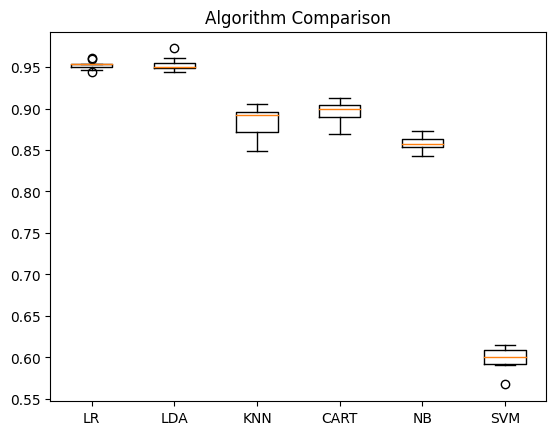

In [353]:
# compare algorithms
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Load dataset
# Split-out validation dataset
array = matchplay_stats_agg.values
X = array[:,0:10]
y = array[:,10]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [379]:
# make predictions
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
# Load dataset

# Split-out validation dataset
array = matchplay_stats_agg.values
X = array[:,0:10]
y = array[:,10]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)
# Make predictions on validation dataset
model = LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9571322985957132
[[656  26]
 [ 32 639]]
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       682
         1.0       0.96      0.95      0.96       671

    accuracy                           0.96      1353
   macro avg       0.96      0.96      0.96      1353
weighted avg       0.96      0.96      0.96      1353



In [410]:
validation =  pd.DataFrame(X_validation)
validation['winner'] = Y_validation
validation['predicted_winner'] = predictions

In [418]:
upsets = validation[(validation[9] > 0) & (validation['winner'] == 1) | (validation[9] < 0) & (validation['winner'] == 0)]
as_expected = validation[(validation[9] < 0) & (validation['winner'] == 1) | (validation[9] > 0) & (validation['winner'] == 0)]



In [419]:
as_expected

,0,1,2,3,4,5,6,7,8,9,winner,predicted_winner
0,0.0,-2.0,10.0,0.0,6.0,8.0,0.0,0.0,-3.0,-62.0,1.0,1.0
1,-11.0,-3.0,-3.0,3.0,-4.0,-9.0,-1.0,3.0,5.0,37.0,0.0,0.0
2,2.0,-4.0,9.0,12.0,9.0,3.0,0.0,0.0,-3.0,-106.0,1.0,1.0
3,-5.0,-1.0,3.0,9.0,-1.0,-5.0,-1.0,-0.0,1.0,15.0,0.0,0.0
5,-1.0,-2.0,11.0,11.0,14.0,-5.0,0.0,4.0,3.0,-39.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1346,-2.0,-0.0,5.0,-4.0,-7.0,2.0,-1.0,1.0,3.0,343.0,0.0,0.0
1347,-7.0,-1.0,-4.0,-1.0,-8.0,2.0,-0.0,-2.0,-1.0,25.0,0.0,0.0
1349,6.0,3.0,-2.0,2.0,5.0,-1.0,0.0,1.0,-1.0,-26.0,1.0,1.0
1351,-4.0,5.0,11.0,-4.0,-7.0,6.0,-0.0,3.0,6.0,40.0,0.0,0.0


In [421]:
# you need to make this more straghtforward with regard to who won, whether it's an upset, what the sign of the stats mean, etc.

as_expected.loc[:,'predicted_by_model'] = as_expected['winner'] == as_expected['predicted_winner']
upsets.loc[:,'predicted_by_model'] = upsets['winner'] == upsets['predicted_winner']

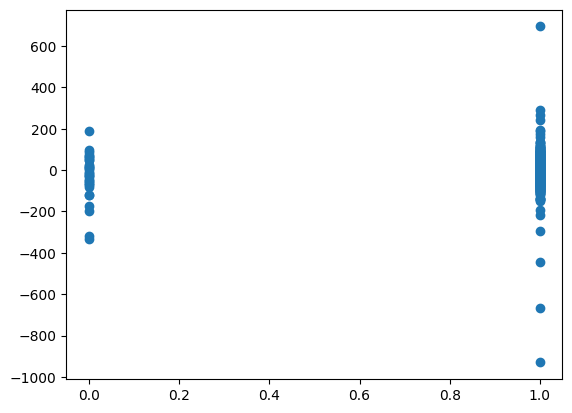

In [422]:
plt.scatter(upsets['predicted_by_model'], upsets[9])
